In [10]:
!pip install wordcloud

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from copy import deepcopy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
StopWords = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib as jb

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sohamkhopkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [14]:

df = pd.read_csv('amazon_alexa.tsv', delimiter = '\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [16]:

df.shape

(3150, 5)

In [18]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


# Exploratory data analysis

In [21]:

df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [23]:
df[df['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [25]:
df.dropna(inplace = True)

df.isnull().sum().sum()

0

In [27]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


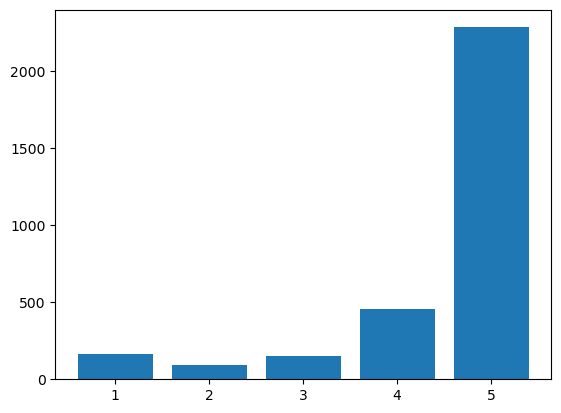

In [29]:
rating_counts = df['rating'].value_counts()
print(rating_counts)
plt.bar(rating_counts.index, rating_counts)
plt.show()

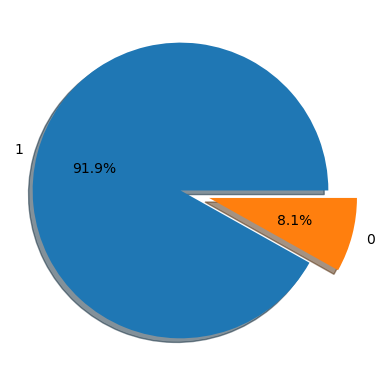

In [31]:
feedback_counts = df['feedback'].value_counts()
plt.pie(feedback_counts, labels = feedback_counts.index, explode = [0.1,0.1], shadow = True, autopct = '%1.1f%%')
plt.show()

In [33]:
neg_review0 = df[df['feedback'] == 0].iloc[0]['verified_reviews']
print("negative feedback: ", neg_review0, '\n')
pos_review0 = df[df['feedback'] == 1].iloc[0]['verified_reviews']
print("positive feedback: ", pos_review0)

negative feedback:  It's like Siri, in fact, Siri answers more accurately then Alexa.  I don't see a real need for it in my household, though it was a good bargain on prime day deals. 

positive feedback:  Love my Echo!


In [35]:
ratings_neg = df[df['feedback'] == 0]['rating'].value_counts()
print("ratings of negative feedbacks\n",ratings_neg, '\n')

ratings_pos = df[df['feedback'] == 1]['rating'].value_counts()
print("ratings of positive feedbacks\n",ratings_pos)

ratings of negative feedbacks
 rating
1    161
2     95
Name: count, dtype: int64 

ratings of positive feedbacks
 rating
5    2286
4     455
3     152
Name: count, dtype: int64


variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


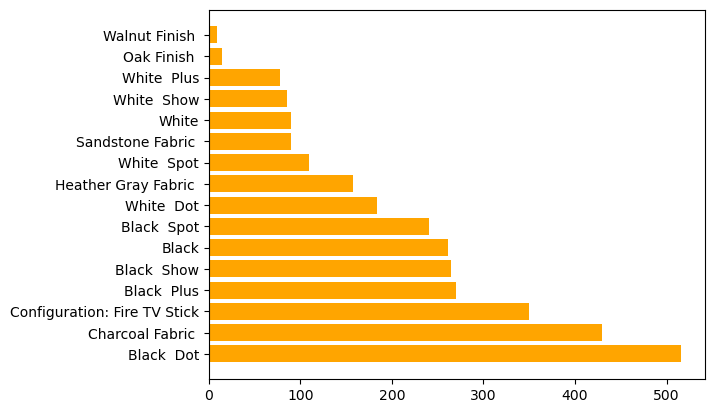

In [37]:
variation_counts = df['variation'].value_counts()
print(variation_counts)
plt.barh(variation_counts.index, variation_counts, color = 'orange')
plt.show()

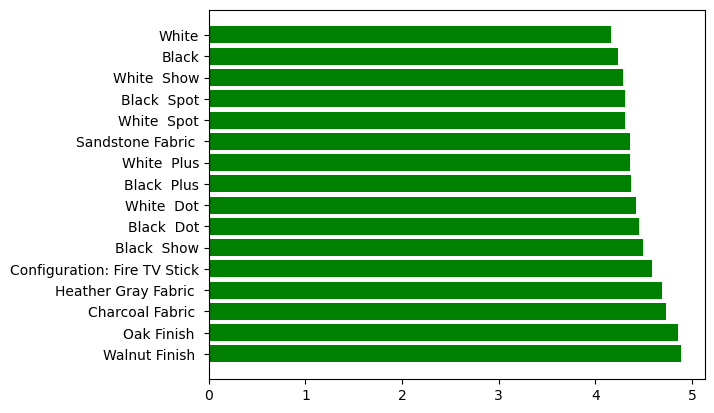

In [88]:
average_ratings = df.groupby('variation')['rating'].mean().sort_values(ascending = False)
plt.barh(average_ratings.index, average_ratings, color = 'green')
plt.show()

0    Love my Echo!
Name: verified_reviews, dtype: object
13
       verified_reviews
count       3149.000000
mean         132.090187
std          182.114569
min            1.000000
25%           30.000000
50%           74.000000
75%          165.000000
max         2851.000000


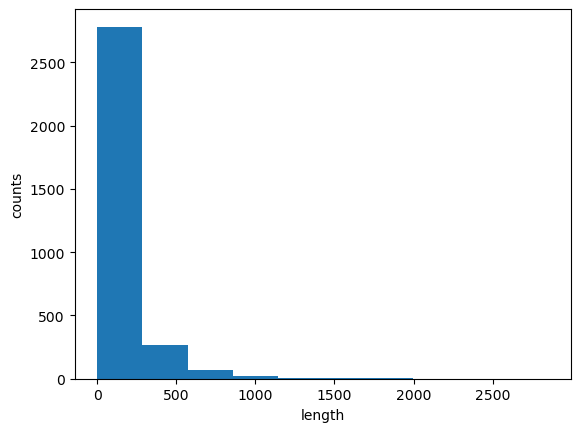

In [41]:
lengths = df['verified_reviews'].apply(len)
print(df['verified_reviews'][:1])
print(lengths[0])
print(pd.DataFrame(lengths).describe())
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('counts')
plt.show()

In [43]:
wc = WordCloud(background_color='white', max_words = 50)

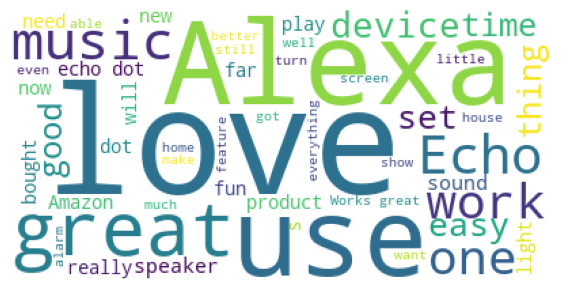

In [98]:
reviews = ' '.join([review for review in df['verified_reviews']])

plt.figure(figsize = (7,7))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.show()

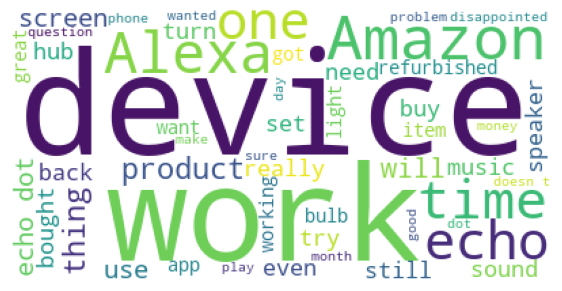

In [102]:
neg_reviews = ' '.join([review for review in df[df['feedback'] == 0]['verified_reviews']])
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(neg_reviews))
plt.axis('off')
plt.show()

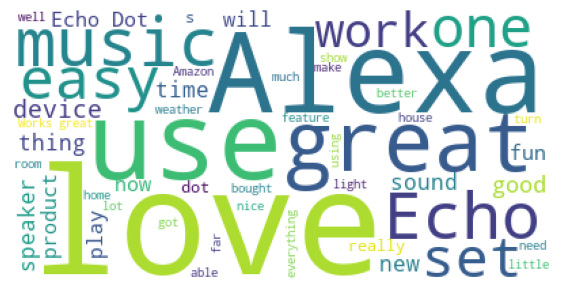

In [104]:
pos_reviews = ' '.join([review for review in df[df['feedback'] == 1]['verified_reviews']])
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(pos_reviews))
plt.axis('off')
plt.show()

# Data Preprocessing

In [52]:
df_processed = deepcopy(df)

## Stemming data

In [55]:
def stemming(content, stemmer):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    
    stop_words = set(stopwords.words('english'))
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if word not in stop_words]
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [57]:
df_processed['verified_reviews'].head()

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [59]:
stemmer = PorterStemmer()

In [61]:
df_processed['verified_reviews'] = df_processed['verified_reviews'].apply(lambda x: stemming(x, stemmer))

In [63]:
df_processed['verified_reviews'].head()

0                                            love echo
1                                                 love
2    sometim play game answer question correctli al...
3    lot fun thing yr old learn dinosaur control li...
4                                                music
Name: verified_reviews, dtype: object

## Vectorize data

In [66]:
vectorizer = CountVectorizer(max_features = 2500)

X = vectorizer.fit_transform(df_processed['verified_reviews']).toarray()

In [68]:
print(X[:3])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Split data

In [71]:
Y = df_processed['feedback']
print(f'x shape {X.shape}')
print(f'y shape {Y.shape}')

x shape (3149, 2500)
y shape (3149,)


In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify = Y, train_size = 0.7, random_state = 42)
print(f'x train shape {x_train.shape}, x test shape {x_test.shape}')
print(f'y train shape {y_train.shape}, y test shape {y_test.shape}')

x train shape (2204, 2500), x test shape (945, 2500)
y train shape (2204,), y test shape (945,)


## Scaling data

In [76]:
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Modeling

In [79]:
def fit_predict(classifier, x_train, y_train, x_test, y_test):
    
    classifier.fit(x_train, y_train)
    
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    print(f'train score is {train_score}, test score is {test_score}')
    
    test_prediction = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, test_prediction) 
    cf_matrix = confusion_matrix(y_test, test_prediction)
    cl_report = classification_report(y_test, test_prediction)
    
    plt.figure(figsize=(7,7))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f'accuracy: {accuracy}\nclassification report:\n{cl_report}', '\n\n')
    
    return classifier

In [81]:
models = {
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC(),
    'XGBClassifier':XGBClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier()
}

LogisticRegression:

train score is 0.9632486388384754, test score is 0.9259259259259259


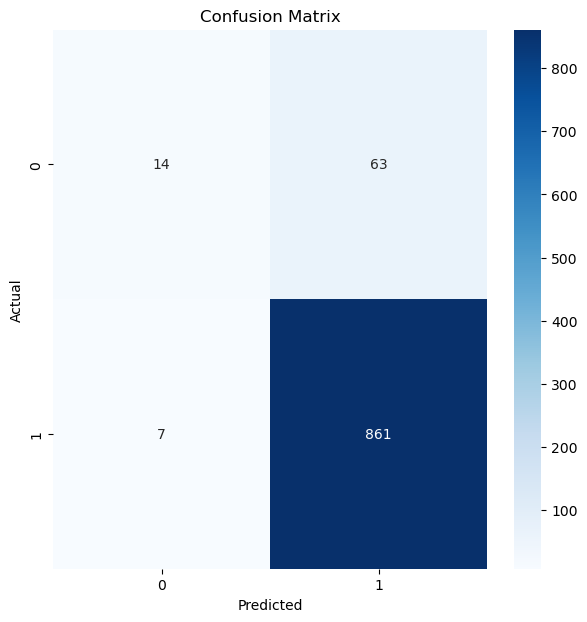

accuracy: 0.9259259259259259
classification report:
              precision    recall  f1-score   support

           0       0.67      0.18      0.29        77
           1       0.93      0.99      0.96       868

    accuracy                           0.93       945
   macro avg       0.80      0.59      0.62       945
weighted avg       0.91      0.93      0.91       945
 


LinearSVC:

train score is 0.9891107078039928, test score is 0.9333333333333333


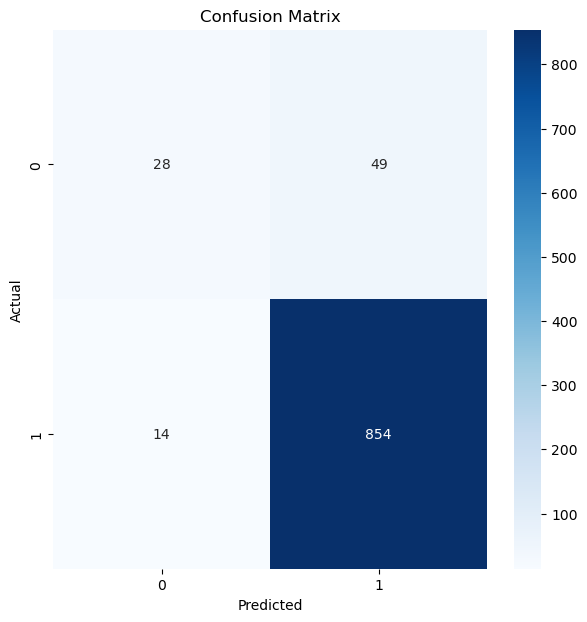

accuracy: 0.9333333333333333
classification report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        77
           1       0.95      0.98      0.96       868

    accuracy                           0.93       945
   macro avg       0.81      0.67      0.72       945
weighted avg       0.92      0.93      0.92       945
 


XGBClassifier:

train score is 0.9732304900181489, test score is 0.9343915343915344


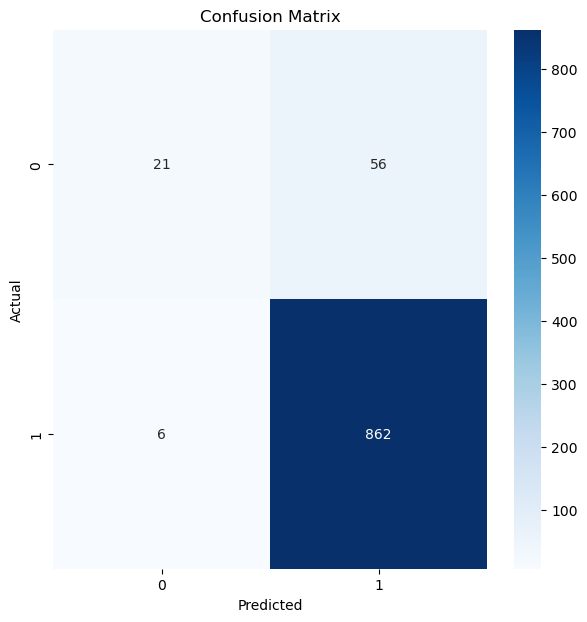

accuracy: 0.9343915343915344
classification report:
              precision    recall  f1-score   support

           0       0.78      0.27      0.40        77
           1       0.94      0.99      0.97       868

    accuracy                           0.93       945
   macro avg       0.86      0.63      0.68       945
weighted avg       0.93      0.93      0.92       945
 


DecisionTreeClassifier:

train score is 0.9927404718693285, test score is 0.9195767195767196


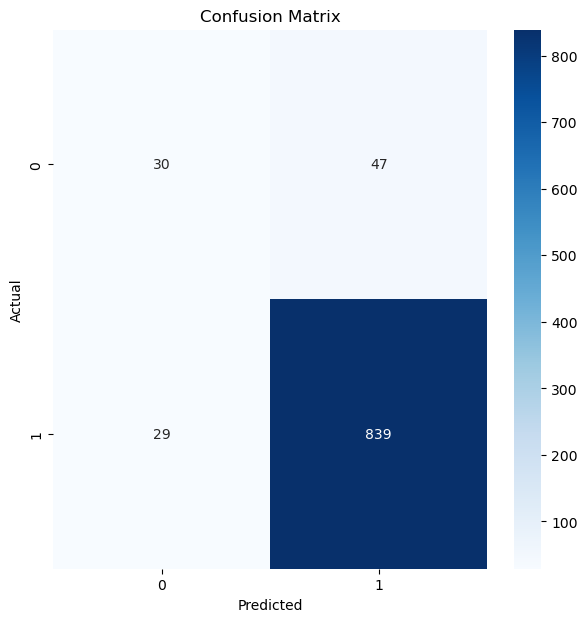

accuracy: 0.9195767195767196
classification report:
              precision    recall  f1-score   support

           0       0.51      0.39      0.44        77
           1       0.95      0.97      0.96       868

    accuracy                           0.92       945
   macro avg       0.73      0.68      0.70       945
weighted avg       0.91      0.92      0.91       945
 


RandomForestClassifier:

train score is 0.9927404718693285, test score is 0.9365079365079365


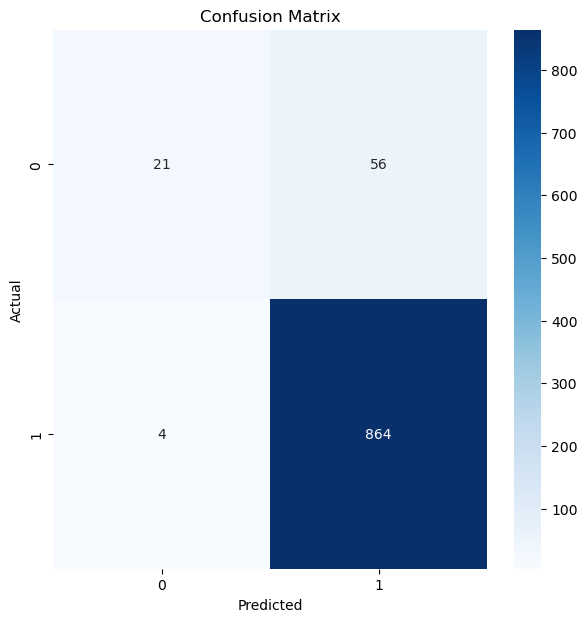

accuracy: 0.9365079365079365
classification report:
              precision    recall  f1-score   support

           0       0.84      0.27      0.41        77
           1       0.94      1.00      0.97       868

    accuracy                           0.94       945
   macro avg       0.89      0.63      0.69       945
weighted avg       0.93      0.94      0.92       945
 


GradientBoostingClassifier:

train score is 0.9578039927404719, test score is 0.9238095238095239


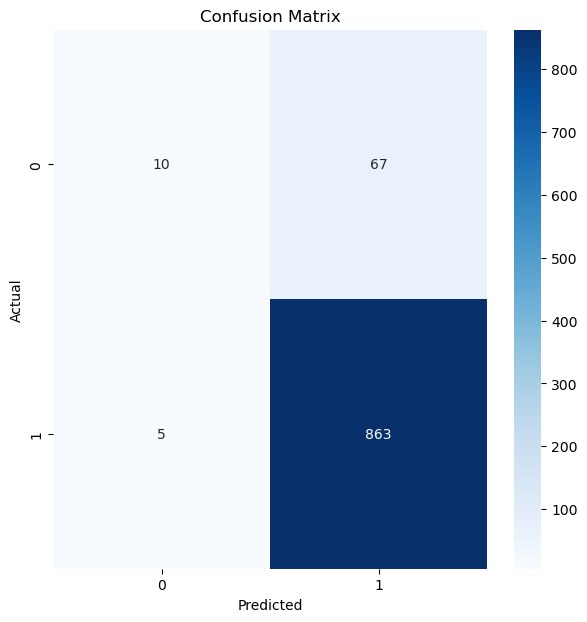

accuracy: 0.9238095238095239
classification report:
              precision    recall  f1-score   support

           0       0.67      0.13      0.22        77
           1       0.93      0.99      0.96       868

    accuracy                           0.92       945
   macro avg       0.80      0.56      0.59       945
weighted avg       0.91      0.92      0.90       945
 




In [83]:
trained_models = {}
for name, model in models.items():
    print(f'{name}:\n')
    model = fit_predict(model, x_train_scaled, y_train, x_test_scaled, y_test)
    trained_models[name] = deepcopy(model)